In [6]:
!pip install s2sphere
!pip install geopandas
!pip install tqdm

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import s2sphere
import matplotlib.patches as patches
from tqdm import tqdm
import os


In [8]:
# --- CONFIGURAZIONE PERCORSI ---
from pathlib import Path

# Trova la radice del progetto (dove c'è il README.md)
def find_project_root():
    current = Path.cwd()
    while current != current.parent:
        if (current / 'README.md').exists() and (current / 'data').exists():
            return current
        current = current.parent
    return Path.cwd()

PROJECT_ROOT = find_project_root()

# Definisci i percorsi in modo relativo alla radice
INPUT_TRAIN = PROJECT_ROOT / "data" / "metadata" / "places-classification" / "train_with_predictions.csv"
INPUT_TEST = PROJECT_ROOT / "data" / "metadata" / "places-classification" / "test_with_predictions.csv"
OUTPUT_TRAIN = PROJECT_ROOT / "data" / "metadata" / "s2-geo-cells" / "train_with_geocells_labels.csv"
OUTPUT_TEST = PROJECT_ROOT / "data" / "metadata" / "s2-geo-cells" / "test_with_geocells_labels.csv"

# --- CARICAMENTO DATI E MAPPA ---
print("Caricamento dati per la mappa di densità...")
df = pd.read_csv(INPUT_TRAIN)

Caricamento dati per la mappa di densità...


In [10]:
PROJECT_ROOT

WindowsPath('c:/Users/Utente/Desktop/vision/Progetto/GeoLoc-CVCS')

Caricamento mappa USA...


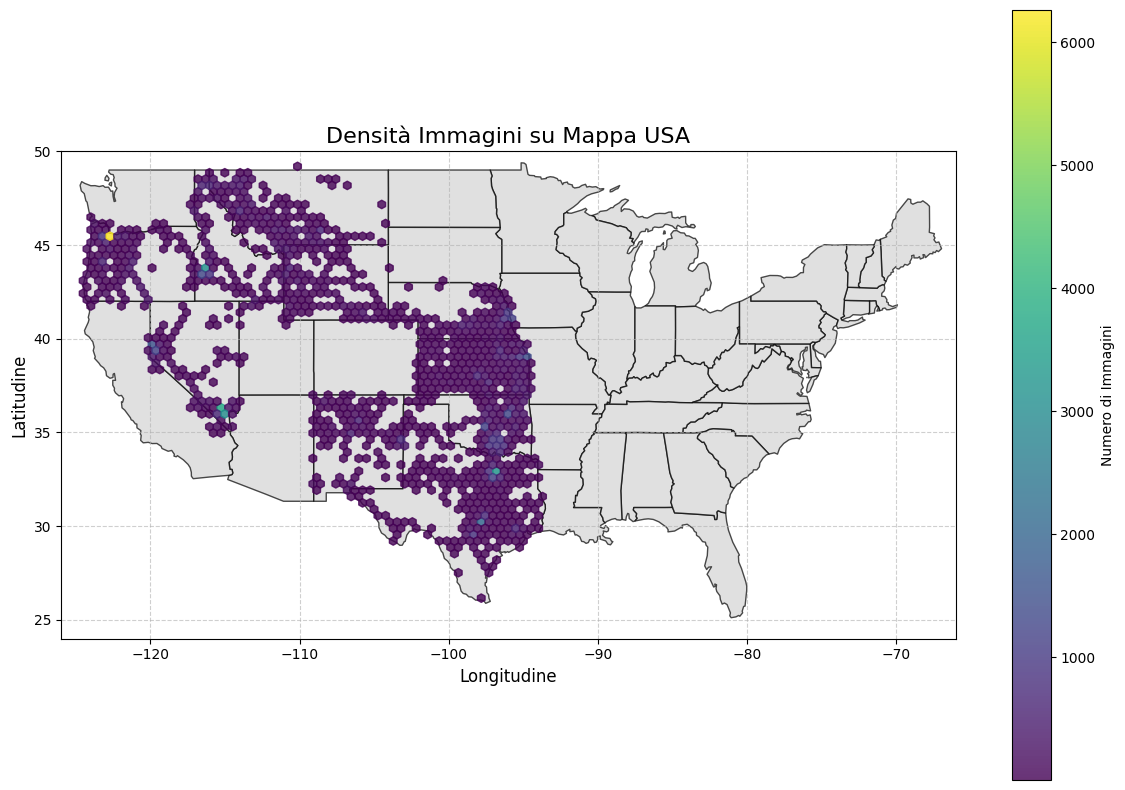


--- Mappa di Densità Completata ---


In [11]:
#Density plot
print("Caricamento mappa USA...")
usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(usa_url)
usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# --- PLOT DELLA DENSITÀ SU MAPPA USA ---
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Disegniamo la mappa degli USA come sfondo
usa.plot(ax=ax, color='lightgray', edgecolor='black', zorder=1, alpha=0.7)

# Hexbin per la densità dei punti
hb = ax.hexbin(df['longitude'], df['latitude'], gridsize=60, cmap='viridis', mincnt=1, alpha=0.8, zorder=2)
plt.colorbar(hb, ax=ax, label='Numero di Immagini')

ax.set_title("Densità Immagini su Mappa USA", fontsize=16)
ax.set_xlabel("Longitudine", fontsize=12)
ax.set_ylabel("Latitudine", fontsize=12)
ax.set_xlim([-126, -66]) # Limiti USA continentali
ax.set_ylim([24, 50])
ax.grid(True, linestyle='--', alpha=0.6) # Aggiungiamo una griglia
plt.tight_layout()
plt.show()

print("\n--- Mappa di Densità Completata ---")

In [12]:
def get_s2_cell_id(lat, lng):
    return s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(lat, lng))

def get_cell_vertices(cell_id):
    cell = s2sphere.Cell(cell_id)
    vertices = []
    for i in range(4):
        vertex = s2sphere.LatLng.from_point(cell.get_vertex(i))
        vertices.append((vertex.lng().degrees, vertex.lat().degrees))
    return vertices

def fast_assign_label(point_s2_id, lookup_dict):
    for lvl in range(30, 3, -1):
        parent_token = point_s2_id.parent(lvl).to_token()
        if parent_token in lookup_dict:
            return lookup_dict[parent_token]
    return -1

def run_partitioning(df_points, tau_max, start_level=4):
    leaf_cells_result = []
    def partition(cell_id, points):
        count = len(points)
        if count <= tau_max or cell_id.level() >= 30:
            if count > 0:
                leaf_cells_result.append({'cell_id': cell_id, 'count': count})
            return
        for i in range(4):
            child = cell_id.child(i)
            child_points = [p for p in points if child.contains(p)]
            if child_points:
                partition(child, child_points)

    initial_cells = df_points['s2_cell'].apply(lambda x: x.parent(start_level)).unique()
    for start_id in initial_cells:
        relevant_points = [p for p in df_points['s2_cell'] if start_id.contains(p)]
        partition(start_id, relevant_points)
    return leaf_cells_result

In [13]:
# --- CARICAMENTO DATI ---
print("🛰️ Caricamento dati...")
df = pd.read_csv(INPUT_TRAIN)
df['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df['latitude'], df['longitude'])]

# --- CONFIGURAZIONI ---
configs = [
    {"name": "config_1", "tau_max": 50},
    {"name": "config_2", "tau_max": 100},
    {"name": "config_3", "tau_max": 200}
]

trained_partitions = {} # Qui salviamo le liste di leaf_cells per il plot
trained_lookups = {}    # Qui salviamo i dizionari per il matching veloce

for cfg in configs:
    print(f"\n🔄 Partizionamento {cfg['name']} (tau_max={cfg['tau_max']})...")

    # 1. Calcolo celle foglia
    leaves = run_partitioning(df, cfg['tau_max'])
    trained_partitions[cfg['name']] = leaves

    # --- AGGIUNTA: Stampa del numero di celle create ---
    num_cells = len(leaves)
    print(f"✅ Numero di celle (classi) create: {num_cells}")
    # --------------------------------------------------

    # 2. Creazione lookup e assegnazione labels
    lookup = {leaf['cell_id'].to_token(): idx for idx, leaf in enumerate(leaves)}
    trained_lookups[cfg['name']] = lookup

    col_name = f"label_{cfg['name']}"
    df[col_name] = [fast_assign_label(p, lookup) for p in tqdm(df['s2_cell'], desc="   Mapping")]

print("\n✅ Calcolo completato.")

🛰️ Caricamento dati...

🔄 Partizionamento config_1 (tau_max=50)...
✅ Numero di celle (classi) create: 5565


   Mapping: 100%|██████████| 119008/119008 [00:06<00:00, 18951.59it/s]



🔄 Partizionamento config_2 (tau_max=100)...
✅ Numero di celle (classi) create: 2858


   Mapping: 100%|██████████| 119008/119008 [00:09<00:00, 11998.26it/s]



🔄 Partizionamento config_3 (tau_max=200)...
✅ Numero di celle (classi) create: 1562


   Mapping: 100%|██████████| 119008/119008 [00:07<00:00, 15546.83it/s]



✅ Calcolo completato.


🗺️ Generazione mappe...


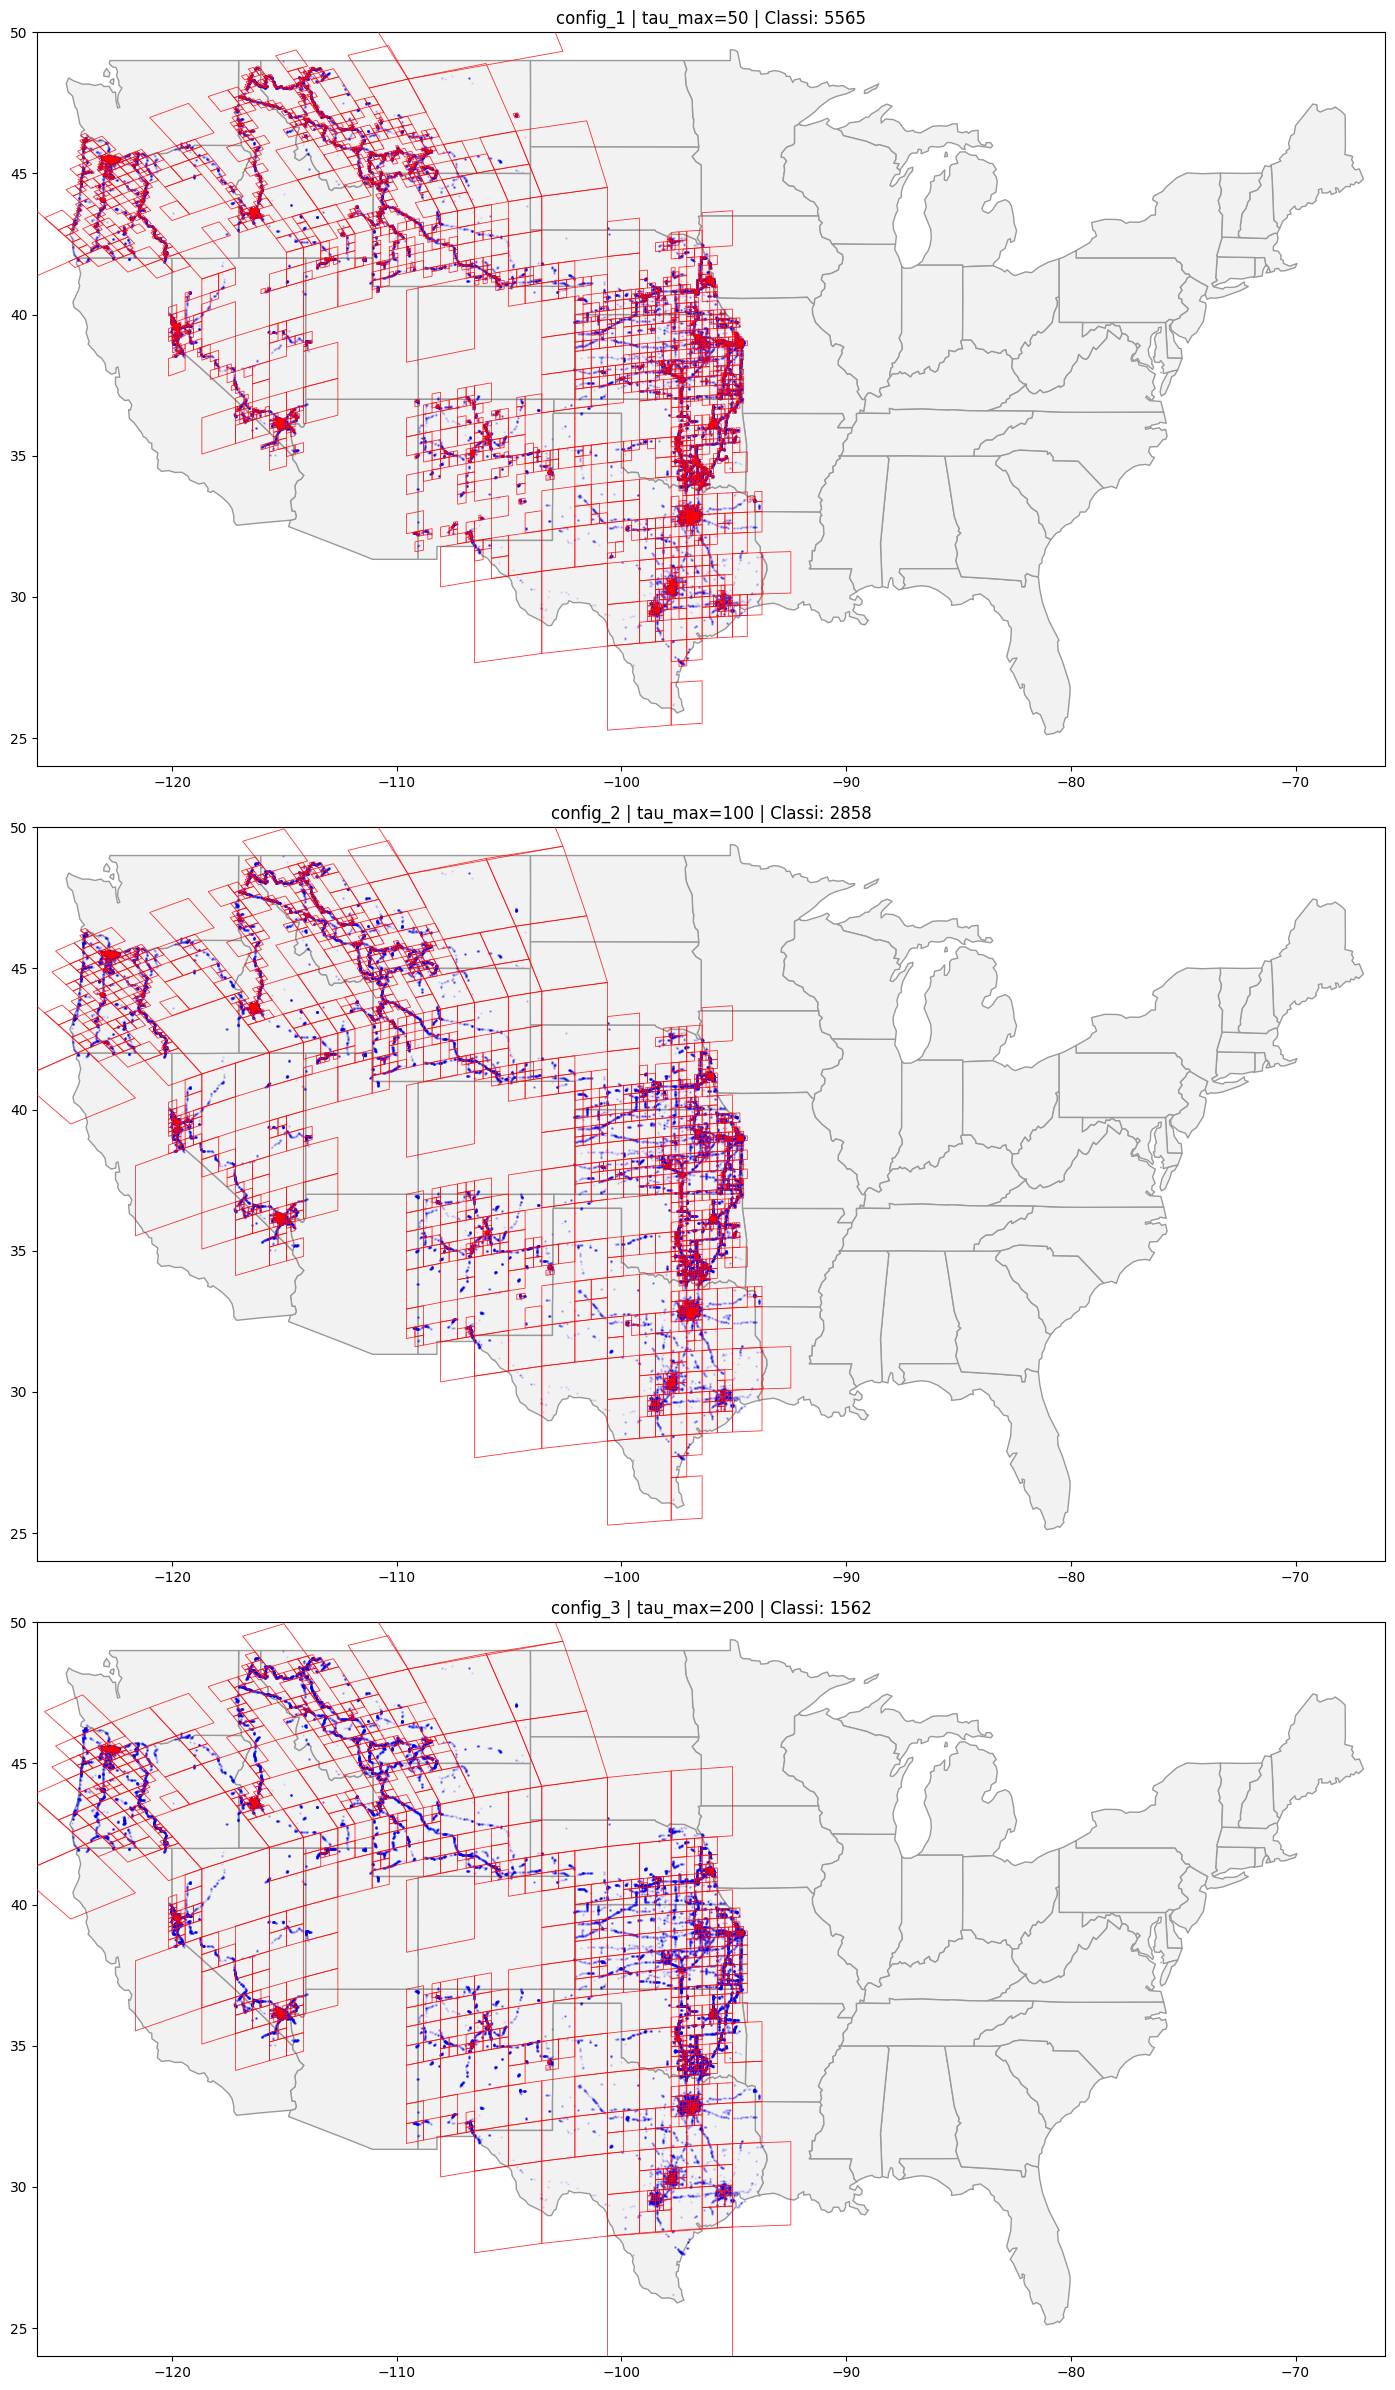

In [14]:
print("🗺️ Generazione mappe...")
usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(usa_url)
usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

fig, axes = plt.subplots(len(configs), 1, figsize=(15, 8 * len(configs)))
if len(configs) == 1: axes = [axes]

for i, cfg in enumerate(configs):
    ax = axes[i]
    name = cfg['name']
    leaf_cells = trained_partitions[name]

    usa.plot(ax=ax, color='#f2f2f2', edgecolor='#999999', zorder=1)
    ax.scatter(df['longitude'], df['latitude'], s=0.5, color='blue', alpha=0.1, zorder=2)

    for leaf in leaf_cells:
        verts = get_cell_vertices(leaf['cell_id'])
        polygon = patches.Polygon(verts, linewidth=0.6, edgecolor='red', facecolor='none', alpha=0.8, zorder=3)
        ax.add_patch(polygon)

    ax.set_title(f"{name} | tau_max={cfg['tau_max']} | Classi: {len(leaf_cells)}")
    ax.set_xlim([-126, -66]); ax.set_ylim([24, 50])

plt.tight_layout()
plt.show()

In [15]:
# Salvataggio TRAIN
print("💾 Salvataggio Train Set...")
df.drop(columns=['s2_cell']).to_csv(OUTPUT_TRAIN, index=False)

# Elaborazione e Salvataggio TEST
if os.path.exists(INPUT_TEST):
    print("🧪 Elaborazione Test Set...")
    df_test = pd.read_csv(INPUT_TEST)
    df_test['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df_test['latitude'], df_test['longitude'])]

    for cfg in configs:
        name = cfg['name']
        lookup = trained_lookups[name]
        df_test[f"target_label_{name}"] = [fast_assign_label(p, lookup) for p in tqdm(df_test['s2_cell'], desc=f"   Matching {name}")]

    df_test.drop(columns=['s2_cell']).to_csv(OUTPUT_TEST, index=False)
    print(f"✅ File salvati:\n - {OUTPUT_TRAIN}\n - {OUTPUT_TEST}")
else:
    print("⚠️ File test non trovato, salvato solo il train.")

💾 Salvataggio Train Set...
🧪 Elaborazione Test Set...


   Matching config_3: 100%|██████████| 10110/10110 [00:00<00:00, 12668.47it/s]


✅ File salvati:
 - c:\Users\Utente\Desktop\vision\Progetto\GeoLoc-CVCS\data\metadata\s2-geo-cells\train_with_geocells_labels.csv
 - c:\Users\Utente\Desktop\vision\Progetto\GeoLoc-CVCS\data\metadata\s2-geo-cells\test_with_geocells_labels.csv


In [16]:
train_path = OUTPUT_TRAIN
test_path = OUTPUT_TEST

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

configs = ["config_1", "config_2", "config_3"]

print("🔍 --- CONTEGGIO IMMAGINI NON ASSEGNATE (LABEL -1) --- 🔍\n")

for cfg in configs:
    train_col = f"label_{cfg}"
    test_col = f"target_label_{cfg}"

    print(f"📊 {cfg.upper()}:")

    # Conteggio per il TRAIN
    n_minus_1_train = (df_train[train_col] == -1).sum()
    perc_train = (n_minus_1_train / len(df_train)) * 100
    print(f"   [TRAIN] Immagini con -1: {n_minus_1_train} su {len(df_train)} ({perc_train:.2f}%)")

    # Conteggio per il TEST
    if test_col in df_test.columns:
        n_minus_1_test = (df_test[test_col] == -1).sum()
        perc_test = (n_minus_1_test / len(df_test)) * 100
        print(f"   [TEST ] Immagini con -1: {n_minus_1_test} su {len(df_test)} ({perc_test:.2f}%)")

    print("-" * 40)

🔍 --- CONTEGGIO IMMAGINI NON ASSEGNATE (LABEL -1) --- 🔍

📊 CONFIG_1:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%)
   [TEST ] Immagini con -1: 1022 su 10110 (10.11%)
----------------------------------------
📊 CONFIG_2:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%)
   [TEST ] Immagini con -1: 472 su 10110 (4.67%)
----------------------------------------
📊 CONFIG_3:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%)
   [TEST ] Immagini con -1: 200 su 10110 (1.98%)
----------------------------------------


In [17]:
df.head()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_sub-region,unique_city,unique_country,creator_username,creator_id,predicted_label,s2_cell,label_config_1,label_config_2,label_config_3
0,175846147796767,31.807977,-109.051129,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743210350,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cde1b03a05,4,2,2
1,327253605472404,31.805039,-109.053170,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743197630,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d1b8c7fbd3,4,2,2
2,4079391105448884,31.795616,-109.059784,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743526750,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d866b60f6b,4,2,2
3,815733012693812,31.839720,-109.029062,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300841441,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,CellId: 86d990591818b4a1,4,2,2
4,471207127297520,31.812350,-109.048174,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743448990,18.0,64.0,"(18, 64)",...,Hidalgo County_New Mexico_US,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cc873be437,4,2,2


In [18]:
df_test.head()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_sub-region,unique_region,unique_country,quadtree_10_1000,creator_username,creator_id,predicted_label,target_label_config_1,target_label_config_2,target_label_config_3
0,1149142498937955,33.076249,-107.307924,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,vxYv3acjdLq3C-PonflwGg,1514582785668,19.0,65.0,"(19, 65)",...,Sierra County_New Mexico_US,New Mexico_US,US,2400,james_mapillary,1.077295e+14,Natural,-1,16,11
1,530975244564913,33.756863,-98.857817,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,Us5lT6SS5UwyXSeqvyIWrA,1566834580000,21.0,65.0,"(21, 65)",...,Archer County_Texas_US,Texas_US,US,2444,fta,1.004782e+14,Natural,2091,1059,583
2,364891741617690,46.876285,-112.083571,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crLSZTuQn8b5tCQNgRggBQ,1454853906828,18.0,75.0,"(18, 75)",...,Lewis and Clark County_Montana_US,Montana_US,US,5192,drkludge,1.106021e+14,Natural,3085,1590,864
3,1134460720387154,37.826379,-96.894420,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,cp18y4qeemjv3qmtdhlgfg,1478958427000,22.0,68.0,"(22, 68)",...,Butler County_Kansas_US,Kansas_US,US,2913,toebee,1.096903e+14,Natural,1192,614,339
4,168140228443695,46.296038,-113.315821,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,eNfRUn9PxXH3O5Bm4qlCjQ,1473983600670,17.0,75.0,"(17, 75)",...,Granite County_Montana_US,Montana_US,US,5183,chrisbeddow,1.058675e+14,Natural,-1,-1,-1
